In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!wget --no-check-certificate https://www.cse.chalmers.se/~richajo/dit866/assignments/a5/a5_data.zip

--2024-03-07 18:07:04--  https://www.cse.chalmers.se/~richajo/dit866/assignments/a5/a5_data.zip
Resolving www.cse.chalmers.se (www.cse.chalmers.se)... 129.16.222.93
Connecting to www.cse.chalmers.se (www.cse.chalmers.se)|129.16.222.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228785031 (218M) [application/zip]
Saving to: ‘a5_data.zip’

a5_data.zip         100%[===================>] 218.19M  17.7MB/s    in 14s     

2024-03-07 18:07:19 (15.9 MB/s) - ‘a5_data.zip’ saved [228785031/228785031]



In [3]:
!unzip /content/a5_data.zip

Streaming output truncated to the last 5000 lines.
  inflating: a5_data/train/MEL/0349.png  
  inflating: a5_data/train/MEL/2019.png  
 extracting: a5_data/train/MEL/2727.png  
  inflating: a5_data/train/MEL/1927.png  
  inflating: a5_data/train/MEL/0174.png  
  inflating: a5_data/train/MEL/2897.png  
  inflating: a5_data/train/MEL/1669.png  
  inflating: a5_data/train/MEL/2006.png  
  inflating: a5_data/train/MEL/0185.png  
  inflating: a5_data/train/MEL/1591.png  
  inflating: a5_data/train/MEL/2166.png  
  inflating: a5_data/train/MEL/0342.png  
  inflating: a5_data/train/MEL/1317.png  
  inflating: a5_data/train/MEL/0610.png  
 extracting: a5_data/train/MEL/2559.png  
  inflating: a5_data/train/MEL/0765.png  
  inflating: a5_data/train/MEL/0745.png  
  inflating: a5_data/train/MEL/1453.png  
  inflating: a5_data/train/MEL/1899.png  
  inflating: a5_data/train/MEL/1316.png  
  inflating: a5_data/train/MEL/1999.png  
  inflating: a5_data/train/MEL/2386.png  
  inflating: a5_data/trai

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
from tqdm import tqdm
import random
import math
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

C:\Anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data Augmentation functions

## Random grayscaling to "force" model to learn features independent of color variables

In [2]:
class RandomGrayscale(object):
  """Randomly converts image to grayscale."""

  def __init__(self, p=0.5):
    self.p = p  # probability of converting to grayscale

  def __call__(self, img):
    """
    Randomly converts the image to grayscale.

    Args:
        img: PIL image.

    Returns:
        PIL image (grayscale or RGB).
    """
    if random.random() < self.p:
      img = transforms.functional.rgb_to_grayscale(img, 3)  # Convert to grayscale
    return img

## Random flipping to "force" model to focus on relevant regions

In [3]:
class RandomFlip(object):
  """Randomly flips images horizontally or vertically."""

  def __init__(self, p_h=0.5, p_v=0.5):
    self.p_h = p_h  # probability of horizontal flip
    self.p_v = p_v  # probability of vertical flip

  def __call__(self, img):
    """
    Apply random horizontal or vertical flip to the image.

    Args:
        img: PIL image.

    Returns:
        PIL image with random flip applied.
    """
    if random.random() < self.p_h:
      img = transforms.functional.hflip(img)  # horizontal flip
    if random.random() < self.p_v:
      img = transforms.functional.vflip(img)  # vertical flip
    return img


### Composing the transformation functions

In [4]:
# Define your overall transformations
transform = transforms.Compose([
    RandomFlip(p_h=0.5, p_v=0.5),  # Random horizontal and vertical flip (50% chance each)
    RandomGrayscale(p=0.3),  # Random grayscale conversion (30% chance)
    transforms.ToTensor(),  # Convert to PyTorch tensor
    # ... other desired transformations (e.g., normalization)
])

# Load data

In [11]:
# train_folder = ImageFolder('/content/a5_data/train', transform=torchvision.transforms.ToTensor())
train_folder = ImageFolder('./a5_data/train', transform=transform)
train_loader = DataLoader(train_folder, batch_size=240, shuffle=True)
val_folder = ImageFolder('./a5_data/val', transform=torchvision.transforms.ToTensor())
val_loader = DataLoader(val_folder, batch_size=240, shuffle=True)
test_folder = ImageFolder('./a5_data/test_blind', transform=torchvision.transforms.ToTensor())
test_loader = DataLoader(test_folder, batch_size=240, shuffle=False)

# Training

In [9]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Training wrapper function

In [6]:
def train_classifier(model, train_data, val_data, hyperparams):

    # Deals with model updates. Adam is more effective than SGD.
    optimizer = torch.optim.AdamW(model.parameters(), lr=hyperparams['lr'])

    # Cross-entropy loss because we have 10 classes.
    # Note that the softmax is "baked into" this loss, so we should not
    # use a softmax at the end.
    loss_func = torch.nn.CrossEntropyLoss()

    # Some statistics.
    acc_history = []

    for epoch in range(hyperparams['n_epochs']):

        # Set the model in training mode, enabling dropout if we use that.
        model.train()

        loss_sum = 0

        # For each batch
        for Xbatch, Ybatch in tqdm(train_data):

            # Apply the model. We don't know at this point what the model is.
            # The output should be of the shape (batch_size, 10).
            outputs = model(Xbatch)

            # Apply the cross-entropy loss.
            loss = loss_func(outputs, Ybatch)

            # Update the model.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_sum += loss.item()

        # Set the model in evaluation mode. Disables dropout if present.
        model.eval()
        with torch.no_grad():
            # Compute the accuracy on the validation data.
            val_acc = predict_and_evaluate(model, val_data)

        mean_loss = loss_sum / len(train_data)

        acc_history.append(val_acc)

        print(f'Epoch {epoch+1}: loss = {mean_loss:.4f}, val acc = {val_acc:.4f}')

    return acc_history

## Evaluation helper function

In [7]:
# A utility function to compute accuracies during training.
def predict_and_evaluate(model, data):

    all_gold = []
    all_pred = []

    for Xbatch, Ybatch in data:
        outputs = model(Xbatch)
        predictions = outputs.argmax(dim=1)

        all_gold.extend(Ybatch.numpy())
        all_pred.extend(predictions.numpy())

    return accuracy_score(all_gold, all_pred)

## Base CNN architecture implementation using the nn.module

In [8]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # Input: 128x128, Output: 128x128
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 64x64
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Input: 64x64, Output: 64x64
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 32x32
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # Input: 32x32, Output: 32x32
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 16x16
    self.fc1 = nn.Linear(128 * 16 * 16, 1024)  # Fully connected layer
    self.fc2 = nn.Linear(1024, 2)  # Output layer

  def forward(self, x):
    # Apply convolutional and pooling layers
    x = F.relu(self.conv1(x))  # Apply ReLU activation after convolution
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = F.relu(self.conv3(x))
    x = self.pool3(x)

    # Flatten the output from the last convolutional layer
    x = x.view(-1, 128 * 16 * 16)  # Flatten all dimensions except batch size

    # Apply fully connected layers
    x = F.relu(self.fc1(x))  # Apply ReLU activation
    x = self.fc2(x)

    return x


In [ ]:
model = ConvNet().to(device)

In [ ]:
history = train_classifier(model, train_loader, val_loader, {'lr': 1e-2, 'n_epochs': 8})

## CNN with batch normalization

In [9]:
# BN
class ConvNetBN(nn.Module):
  def __init__(self):
    super(ConvNetBN, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # Input: 128x128, Output: 128x128
    self.bn1 = nn.BatchNorm2d(32)  # Batch normalization after conv1
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 64x64

    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Input: 64x64, Output: 64x64
    self.bn2 = nn.BatchNorm2d(64)  # Batch normalization after conv2
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 32x32
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # Input: 32x32, Output: 32x32

    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 16x16
    self.bn3 = nn.BatchNorm2d(128)  # Batch normalization after conv3
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc1 = nn.Linear(128 * 16 * 16, 1024)  # Fully connected layer
    self.fc2 = nn.Linear(1024, 2)  # Output layer

  def forward(self, x):
    # Apply convolutional and pooling layers
    x = F.relu(self.bn1(self.conv1(x)))  # Apply ReLU activation after convolution
    x = self.pool1(x)
    x = F.relu(self.bn2(self.conv2(x)))
    x = self.pool2(x)
    x = F.relu(self.bn3(self.conv3(x)))
    x = self.pool3(x)

    # Flatten the output from the last convolutional layer
    x = x.view(-1, 128 * 16 * 16)  # Flatten all dimensions except batch size

    # Apply fully connected layers
    x = F.relu(self.fc1(x))  # Apply ReLU activation
    x = self.fc2(x)

    return x


In [ ]:
modelBN = ConvNetBN().to(device)
history = train_classifier(modelBN, train_loader, val_loader, {'lr': 1e-2, 'n_epochs': 10})

100%|██████████| 27/27 [06:34<00:00, 14.61s/it]


Epoch 1: loss = 63.2466, val acc = 0.6581


100%|██████████| 27/27 [06:36<00:00, 14.69s/it]


Epoch 2: loss = 0.8299, val acc = 0.7021


100%|██████████| 27/27 [06:48<00:00, 15.12s/it]


Epoch 3: loss = 0.6533, val acc = 0.7117


100%|██████████| 27/27 [06:47<00:00, 15.09s/it]


Epoch 4: loss = 0.5598, val acc = 0.7157


100%|██████████| 27/27 [06:38<00:00, 14.77s/it]


Epoch 5: loss = 2.1504, val acc = 0.7141


100%|██████████| 27/27 [06:46<00:00, 15.06s/it]


Epoch 6: loss = 1.0680, val acc = 0.7436


100%|██████████| 27/27 [06:58<00:00, 15.50s/it]


Epoch 7: loss = 0.5846, val acc = 0.7564


100%|██████████| 27/27 [06:41<00:00, 14.87s/it]


Epoch 8: loss = 0.4969, val acc = 0.7740


100%|██████████| 27/27 [06:52<00:00, 15.30s/it]


Epoch 9: loss = 0.4886, val acc = 0.7668


100%|██████████| 27/27 [06:47<00:00, 15.08s/it]


Epoch 10: loss = 0.4775, val acc = 0.7804


In [ ]:
model_path = "/content/drive/MyDrive/Colab Notebooks/my_modelBN.pth"

# Save the model's state_dict
torch.save(modelBN.state_dict(), model_path)

print(f"Model saved to {model_path}")

## Transfer Learning with VGG16

In [15]:
class VGGTransferModel(nn.Module):
  def __init__(self):
    super(VGGTransferModel, self).__init__()
    vgg16 = models.vgg16(pretrained=True)
    # Freeze VGG16 features
    for param in vgg16.features.parameters():
      param.requires_grad = False
    # Use the first few layers of VGG16 features as feature extractor
    self.feature_extractor = vgg16.features[:15]  # Replace N with desired number of layers

    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # Input: 128x128, Output: 128x128
    self.bn1 = nn.BatchNorm2d(32)  # Batch normalization after conv1
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 64x64

    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Input: 64x64, Output: 64x64
    self.bn2 = nn.BatchNorm2d(64)  # Batch normalization after conv2
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 32x32
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # Input: 32x32, Output: 32x32

    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 16x16
    self.bn3 = nn.BatchNorm2d(128)  # Batch normalization after conv3
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc1 = nn.Linear(128 * 16 * 16, 1024)  # Fully connected layer
    self.fc2 = nn.Linear(1024, 2)  # Output layer

  def forward(self, x):
    features = self.feature_extractor(x)
    # Apply convolutional and pooling layers
    x = F.relu(self.bn1(self.conv1(x)))  # Apply ReLU activation after convolution
    x = self.pool1(x)
    x = F.relu(self.bn2(self.conv2(x)))
    x = self.pool2(x)
    x = F.relu(self.bn3(self.conv3(x)))
    x = self.pool3(x)

    # Flatten the output from the last convolutional layer
    x = x.view(-1, 128 * 16 * 16)  # Flatten all dimensions except batch size

    # Apply fully connected layers
    x = F.relu(self.fc1(x))  # Apply ReLU activation
    x = self.fc2(x)

    return x


In [13]:
vgg_model = VGGTransferModel()
history = train_classifier(vgg_model, train_loader, val_loader, {'lr': 1e-4, 'n_epochs': 8})

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [02:50<00:00,  6.30s/it]


Epoch 1: loss = 1.0485, val acc = 0.7252


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [02:47<00:00,  6.21s/it]


Epoch 2: loss = 0.4570, val acc = 0.7772


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [02:46<00:00,  6.17s/it]


Epoch 3: loss = 0.4244, val acc = 0.7963


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [02:46<00:00,  6.18s/it]


Epoch 4: loss = 0.4066, val acc = 0.8075


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [02:46<00:00,  6.18s/it]


Epoch 5: loss = 0.3902, val acc = 0.8291


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [17:50<00:00, 39.65s/it]


Epoch 6: loss = 0.3797, val acc = 0.8387


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [02:59<00:00,  6.64s/it]


Epoch 7: loss = 0.3688, val acc = 0.8283


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [02:59<00:00,  6.63s/it]


Epoch 8: loss = 0.3581, val acc = 0.8371


In [14]:
model_path = "./vgg_modelBN.pth"

# Save the model's state_dict
torch.save(vgg_model.state_dict(), model_path)

print(f"Model saved to {model_path}")

Model saved to ./vgg_modelBN.pth


# Testing

## Loading Model

In [16]:
model_path = "./vgg_modelBN.pth"

model_state_dict = torch.load(model_path)

model = VGGTransferModel()

model.load_state_dict(model_state_dict)

model.eval()

C:\Users\Xuan Ming\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Xuan Ming\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGGTransferModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(

In [18]:
test_folder_labelled = ImageFolder('./a5_data_test/test', transform=torchvision.transforms.ToTensor())
test_loader_labelled = DataLoader(test_folder_labelled, batch_size=240, shuffle=False)

In [19]:
predict_and_evaluate(model, test_loader_labelled)

0.8279648609077599

# Blind Test

## Predict helper function

In [17]:
def predict_label(image, model):
  """Predicts label (MEL or NV) for a given image."""
  with torch.no_grad():
    output = model(image.unsqueeze(0))  # Add batch dimension
    predicted_class = torch.argmax(output, dim=1).item()
  return train_folder.classes[predicted_class]  # Use training class labels

## Write to text file as per format stated in assignment

In [ ]:
# Write predictions to text file
with open("predictions.txt", "w") as f:
  for image, _ in test_folder:
    predicted_label = predict_label(image, model)
    # Get filename without path
    f.write(f"{predicted_label}\n")

print("Predictions written to predictions.txt")

Predictions written to predictions.txt


### Sanity check

In [ ]:
with open("predictions.txt") as f:
    guesses = [l.strip() for l in f]
    assert(len(guesses) == 1366)
    assert(sorted(set(guesses)) == ['MEL', 'NV'])

# Draft works

Conv Layer output formula
(W-F + 2P)/S + 1
where W = width of image
F = filter size
P = padding
S = stride

In [ ]:
# nn.Conv2d(channel, output channel, kernel/filter size, stride, padding)
# Conv Layer output size formula
# (W-F + 2P)/S + 1
# where W = width of image
# F = filter size
# P = padding
# S = stride

# The Channel to another Conv layer after pooling needs to be same as output channel in previous conv layer
# e.g. image 32x32
# nn.Conv2d(3, 6, 5) = 28x28
# nn.MaxPool2d(2,2) = 14x14
# nn.Conv2d(6, 16, 5) 6 is derived from 1st conv2d layer's output channel

# Pooling layer output formula
# Input / Filter

# nn.Linear(input, output)
# Finally, must be able to get the channel and dimensions of
# the last conv layer to feed into the 1st fully connected layer

# the last fully connected layer's output must correspond to the number of catergory we are classifying


# import torchnn.functional as F
## define loss
# loss = nn.CrossEntropyLoss()

# class ConvNet(nn.Module):
# def __init__(self):
# self.conv1 = nn.Conv2d(3, 6, 3)
# self.conv2 = nn.Conv2d(6, 16, 5)
# self.pool = nn.MaxPool2d(2,2)
# self.fc1 = nn.Linear(16 * 5 * 5, 120)
# self.fc2 = nn.Linear(120, 84)
# self.fc3 = nn.Linear(84, 10)

# def forward(self, x):
# x = self.pool(F.relu(self.conv1(x)))
# x = self.pool(F.relu(self.conv2(x)))
# x = x.view(-1, 16*5*5) # To flatten, auto defined size with -1
# x = F.relu(self.fc1(x))
# x = F.relu(self.fc2(x))
# x = self.fc3(x) # no activation function and no softmax as it is included in loss defined

## Draft: Display loaded images

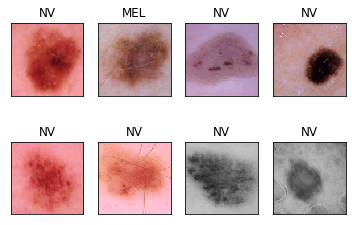

In [22]:
Xexamples, Yexamples = next(iter(train_loader))

for i in range(8):
    plt.subplot(2,4,i+1)
    img = Xexamples[i].numpy().transpose(1, 2, 0)
    plt.imshow(img, interpolation='none')
    plt.title('NV' if Yexamples[i] else 'MEL')
    plt.xticks([])
    plt.yticks([])

## Draft: Sanity check for output at each layers

In [ ]:
conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # Input: 128x128, Output: 128x128
pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 64x64
conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Input: 64x64, Output: 64x64
pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 32x32
conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # Input: 32x32, Output: 32x32
pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 16x16
fc1 = nn.Linear(128 * 16 * 16, 1024)  # Fully connected layer
fc2 = nn.Linear(1024, 2)  # Output layer

x = conv1(Xexamples[0])
print(x.shape)
x = pool1(x)
print(x.shape)
x = conv2(x)
print(x.shape)
x = pool2(x)
print(x.shape)
x = conv3(x)
print(x.shape)
x = pool3(x)
print(x.shape)
x = x.view(-1, 128 * 16 * 16)  # Flatten all dimensions except batch size
print(x.shape)
x = fc1(x)
print(x.shape)
x = fc2(x)
print(x.shape)